# Лабораторная 6
Нейронные сети

Задачи:
1. Провести EDA
2. Построить baseline модель
3. Подобрать параметры для baseline модели

In [182]:
!gdown 1fymPgozbnluvV5dsBOBprnkDSv2om09-
!gdown 17t8juJOYaI0IO5jiGCUiCcdFdyP6Q0z-

Downloading...
From: https://drive.google.com/uc?id=1fymPgozbnluvV5dsBOBprnkDSv2om09-
To: /content/mkrf_shows.csv
100% 62.6k/62.6k [00:00<00:00, 17.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=17t8juJOYaI0IO5jiGCUiCcdFdyP6Q0z-
To: /content/mkrf_movies.csv
100% 3.02M/3.02M [00:00<00:00, 18.2MB/s]


In [183]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import string

# 1 Преобработка данных

In [184]:
r = pd.read_csv("/content/mkrf_shows.csv")
r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   int64  
 1   box_office  3158 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


In [185]:
data = pd.read_csv("/content/mkrf_movies.csv")
display(data.info())
display(data.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

None

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама"
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный"


Итак, данные представляют собой информацию о фильмах из реестра прокатных удостоврений. К фильмам, которые были показаны в России есть также информация о сборах в рублях в отдельном приложении. Таких фильмов 3к из n, пока не понятно как они бьются, все ли эти фильмы представлены в основной таблице.

Пройдемся по признакам:
1. puNumber - тип `object`, хотя должно быть `int`, значит что там подмешано, аналогично с `ratings`
2. `type, film_studio, prod_contry, director, producer, age_reg, genres` - категориальные признаки которые могут быть сильно раздуты, нужно смотерть сколько уникальных значений, возможно придется как то группировать.
3. `rating, genre` - пропусков не так много, заполнять рейтинг опасно, на какой то ноунейм фильм может прилететь хорошая оценка, что как будто сломает модель, а жанр не так критично
4. `non / refundeble, budget, financing_score` - очень много пропусков - признаки под удаление
5. Неинформативные признаки: `title, puNumber,` ~~`start_date`~~ - 100 процентов по дудаление. Однако, насчет даты начала показа, можно предположить, что старые фильмы будут иметь более высокую оценку, так как народ был не насмотрен и много прорывных идей использовалось. Или например в какие то года какой то отдельный жанр был более популярен

Теоретическая работа модели, в моем стереотипном понимании:
- Комбинация именитого режиссера, студии и жанра - высокая оценка
- Старые советские фильмы - хорошая оценка
- Российские фильмы - оценка явно ниже чем у Спилберга или Скорсезе, вплоть до провальной

Объединить таблицы не получиться пока не устраним пробему с `object_type` в столбце `puNumber`, отберем записи, в которых `puNumber` нельзя конвертировать в число

In [186]:
data.loc[np.logical_not(data["puNumber"].str.isnumeric())]


,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
804,Паранормальный Якутск,111004112,2012-08-24T12:00:00.000Z,Художественный,ИП Тимофеев К.П.,Россия,К.Тимофеев,NaN,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,NaN,NaN
1797,Курбан-роман. (История с жертвой),нет,2014-05-15T12:00:00.000Z,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN


Непонятно почему 804 фильм вылез, но 1797 явно все испортил. Удалим, оба так как они практически пустые

Вот кстати к слову, о пропусках в ratings, я загуглил эти 2 фильма, они настолько `underground`, с минимальным бюджетом (60к) без оценки на кинопоиске и разбросом рейтинга на других площадках от 3.3 до 6, что подтвердило мысль об удалении пропусков в rating

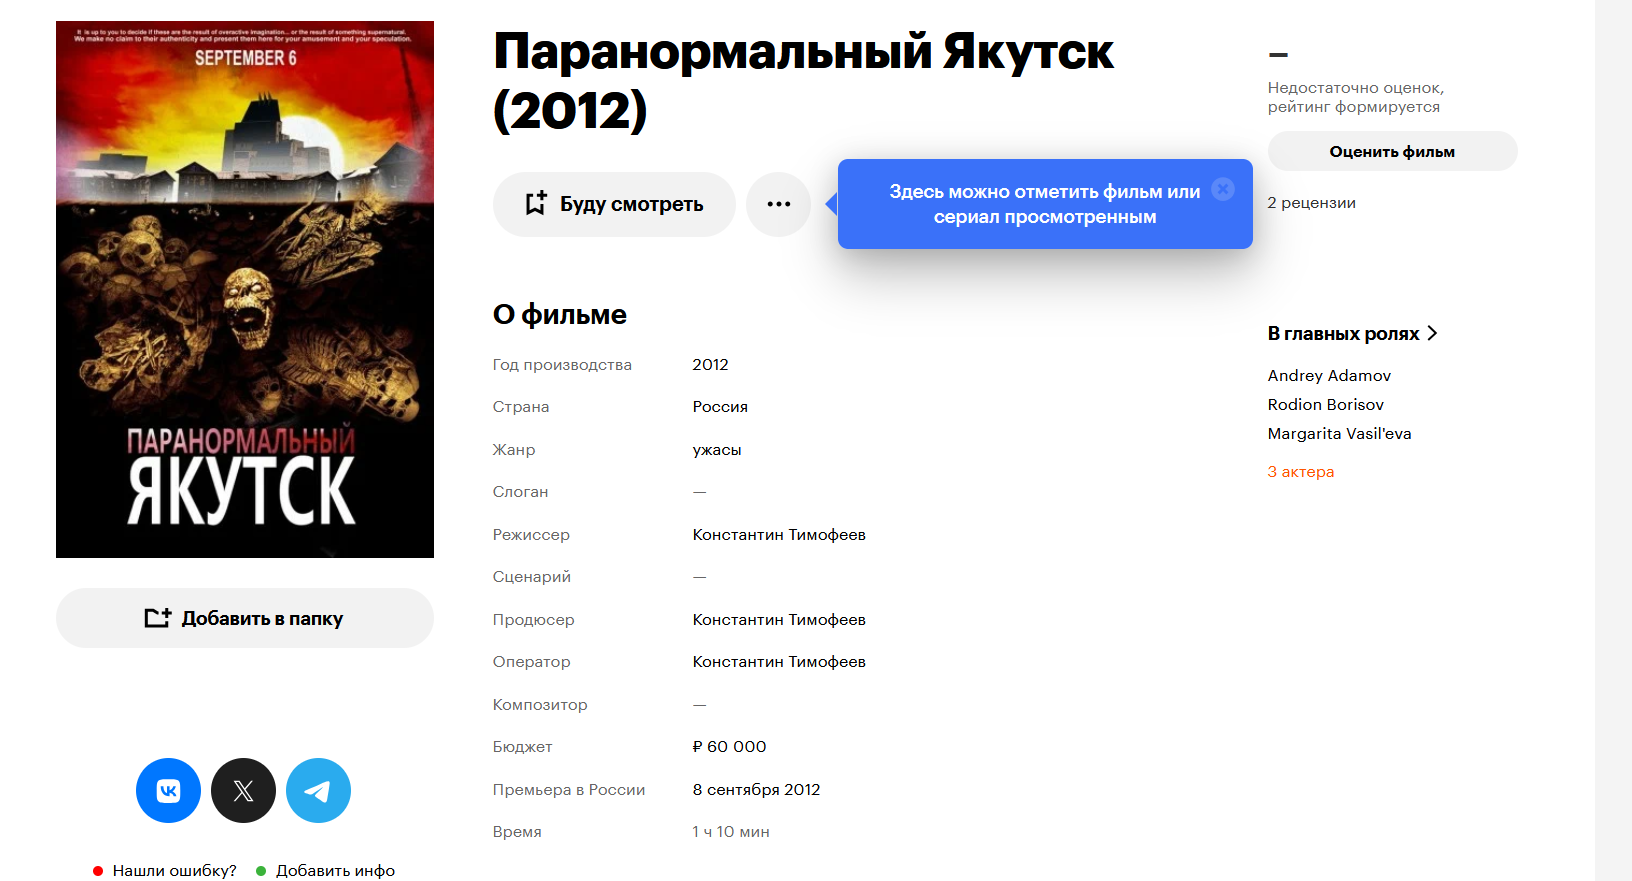


In [187]:
display(data.shape)
data = data.drop(index=data.loc[np.logical_not(data["puNumber"].str.isnumeric())].index)
data.shape
data.puNumber = data.puNumber.astype(np.int64)
data.info()

(7486, 15)

<class 'pandas.core.frame.DataFrame'>
Index: 7484 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7484 non-null   object 
 1   puNumber               7484 non-null   int64  
 2   show_start_date        7484 non-null   object 
 3   type                   7484 non-null   object 
 4   film_studio            7466 non-null   object 
 5   production_country     7482 non-null   object 
 6   director               7475 non-null   object 
 7   producer               6917 non-null   object 
 8   age_restriction        7484 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: float6

Посмотрим как будут выглядить данные при объединении. Варианты объединения:
1. Левое - все что есть в исходной большой таблице, сопоставлем по `puNumber` с правой, там где есть записи заполняем, там где нет ставим Nan, все что не нашло пары отбрасываем. Проблема - +4к записей с пропуском в признаке `box_office`

2. Внутренне - оставляем только пересечения `puNumber`, проблема из 7к записей останеться максимум 3к

3. Полное объединение, как первый вариант, но одиночек не отбразываем, заполняем с Nan, проблема ,возможно, +4к пропусков в каждом признаке или же исход как с левым объединением

Везде проблемы...

Буду использовать левое объединение со следующей схемой разделю признак `box_office` на 2: бинарный и числовой. Если есть данные по сборам то бинарный ставлю 1, а в сборах пишу сбор, если нет ставлю 0 и 0. Подробнее дальше

In [188]:
data = pd.merge(left=data, right=r, on="puNumber", how="left")
data.head(2)

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN


In [189]:
data = data.drop(columns=["title", "puNumber"])

## Обработка пропусков

In [190]:
def draw_null():
  null = data.isna().sum()
  display(null.reset_index().T)

  fig = px.histogram(
      null,
      x=data.columns,
      y=null.values
  )
  fig.update_layout(height=400, width=600)
  fig.show()

In [191]:
draw_null()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
index,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,0,0,18,2,9,567,0,7152,7152,7152,7152,965,974,4326


Пойдем по изначально намеченному плану, дропаем столбцы с 7к+ пропусками, и записи с `ratings` Nan

In [192]:
data = data.drop(columns=["refundable_support", "nonrefundable_support", "budget", "financing_source"])

In [193]:
data = data.dropna(subset=["ratings"])
data.shape

(6519, 10)

Интересно что означают проценты? Долю от 10?

In [194]:
data[data.ratings.str.contains("%")].shape

(29, 10)

In [195]:
data = data.drop(index=data[data.ratings.str.contains("%")].index)
data.ratings = data.ratings.astype(np.float64)

In [196]:
draw_null()

,0,1,2,3,4,5,6,7,8,9
index,show_start_date,type,film_studio,production_country,director,producer,age_restriction,ratings,genres,box_office
0,0,0,5,2,3,478,0,0,6,3591


О как, почти все фильмы с неизвестным рейтингом, не имели и жанра. Удалем оставшуюся мелочевку

In [197]:
data = data.dropna(subset=["film_studio", "production_country", "director", "genres"])
data.shape

(6476, 10)

Заполнение `box_office`.
Как должна работать идея с двумя 0. Если нет информации о сборах и прокате в России, то модель не должна учитывать это, скалярное произведение весов и этих двух признаков будет 0.

Если есть информация о прокате России, значит фильм показывался в большем числе стран, если прокат успешный это хорошо может говорить о том что фильм хороший, если прокат не очень значит фильм не зашел. Применим Standart Scaler к этому признаку он отнормирует данные вокруг 0, отрацательное значение - прокат слабый, положительное - успешный. Ну и соответственно веса в нейроне должны быть положительные для этого признака.

Отрицательное значение проката умножится на положительный вес и снизит рейтинг и наоборот. Логика такая

In [198]:
data["Is_box_office"] = np.where(data.box_office.isna(), 0, 1)
data.box_office = data.box_office.fillna(0)
data.head(1)

,show_start_date,type,film_studio,production_country,director,producer,age_restriction,ratings,genres,box_office,Is_box_office
0,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,7.2,"боевик,драма,мелодрама",0.0,0


In [199]:
draw_null()

,0,1,2,3,4,5,6,7,8,9,10
index,show_start_date,type,film_studio,production_country,director,producer,age_restriction,ratings,genres,box_office,Is_box_office
0,0,0,0,0,0,477,0,0,0,0,0


Признак продюссера будем изменять дальше поэтому пока не заполняем

## Обработка категориальных признаков

`film_studio, director, producer`

Данные признаки имеют много уникальных значений, если их все напрямую переводить в категории, то размерность может вырасти до 15к столбцов. Конечно фильмы Спилберга или Тарантино, скорей всего будут иметь хорошую оценку, но обобщающая способность модели снизится подай ей неизвестного режиссера, если она вообще сможет его обработать =). Лучше как то по-другому подсказать модели что режиссер хороший

В создании некоторых фильмов учавтсвовало несколько продюссеров, студий, режиссеров. Отразим это в новых признаках multi_studios, multi_dir, multi_prod. Также посчитаем количество фильмов для каждой студии, режиссера и продюссера. И создадим признаки известности режиссера, студии, продюссера если они создали больше n фильмов. Придется написать пару костылей

In [200]:
data["multi_producer"] = [1 if (not isinstance(value, float)) and (len(value.split(", ")) > 1) else 0 for value in data.producer.values]
data["multi_dir"] = [1 if (not isinstance(value, float)) and (len(value.split(", ")) > 1) else 0 for value in data.director.values]
data["multi_studio"] = [1 if (not isinstance(value, float)) and (len(value.split(", ")) > 1) else 0 for value in data.film_studio.values]
data.head(2)

,show_start_date,type,film_studio,production_country,director,producer,age_restriction,ratings,genres,box_office,Is_box_office,multi_producer,multi_dir,multi_studio
0,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,7.2,"боевик,драма,мелодрама",0.0,0,1,0,1
1,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,6.6,"драма,военный",0.0,0,0,0,0


Суммируем количество записей и рейтинг фильмов для конкретного признака

In [201]:
def count_f(series: pd.Series, split_char=", "):
  d = {}
  for index, value in series.items():
    if (not isinstance(value, float)):
      for subvalue in value.split(split_char):
          d[subvalue] = d.get(subvalue, np.array((0, 0))) + np.array((1, data.loc[index]["ratings"]))
  return d

In [202]:
dirs = count_f(data.director)
print(f"Уникальных режиссеров: {len(dirs)}")
studios = count_f(data.film_studio)
print(f"Уникальных студий: {len(studios)}")
prods = count_f(data.producer)
print(f"Уникальных продюссеров: {len(prods)}")

Уникальных режиссеров: 4657
Уникальных студий: 9949
Уникальных продюссеров: 8131


In [203]:
print(sorted(dirs.items(), key=lambda x: x[1][1], reverse=True)[:15])
print(sorted(studios.items(), key=lambda x: x[1][1], reverse=True)[:5])
print(sorted(prods.items(), key=lambda x: x[1][1], reverse=True)[:5])


[('Стивен Содерберг', array([ 17. , 120.9])), ('Ридли Скотт', array([ 16. , 113.4])), ('Тиль Швайгер', array([ 15. , 107.1])), ('Питер Джексон', array([ 13. , 104.9])), ('Клинт Иствуд', array([13. , 98.3])), ('Дэвид Финчер', array([12. , 94.9])), ('Л.Гайдай', array([12. , 93.6])), ('Вуди Аллен', array([13. , 92.2])), ('Кристофер Нолан', array([11. , 91.6])), ('Стивен Спилберг', array([12. , 88.9])), ('Гай Ричи', array([11., 87.])), ('Крис Рено', array([12. , 86.3])), ('Люк Бессон', array([12. , 84.7])), ('В.Панжев', array([11. , 79.2])), ('Кевин Смит', array([13. , 78.5]))]
[('Уорнер Бразерс', array([ 411. , 2864.9])), ('Киностудия "Мосфильм"', array([ 349. , 2484.9])), ('Юниверсал Пикчерз', array([ 235. , 1587.2])), ('Канал +', array([ 237. , 1511.5])), ('Сине +', array([141. , 891.6]))]
[('С.Сельянов', array([ 57. , 335.9])), ('Джейсон Блум', array([ 54. , 323.4])), ('Эрик Феллнер', array([ 40. , 274.5])), ('Тим Беван', array([ 30. , 200.3])), ('Майкл Бэй', array([ 25. , 160.2]))]


Если отбирать по количеству снятых фильмов (топ 200 - 5 фильмов) то, у данного подхода есть минус, например, Дени Вильнев, не попал в топ, хотя фильмы у него топовые.

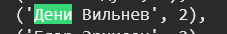

~~За линию проходимся по данным и если попадает в топ то ставим флаг. После обработки удаляем исходные столбцы.~~

UPD поступим по-другому, посчитаем средний рейтинг на основе имеющихся данных и поменям флаг на `is_good_`. Если средний рейтинг больше 6 то это good. Для нескольких записей буду использовать общее средннее. Будем помечать режиссеров, студий и продюссеров которые участвовали в успешных проектах

In [204]:
def set_famous(values, value_map, split_char=", "):
  r = [0] * len(values)
  for index, value in enumerate(values):
    if (not isinstance(value, float)):
      total = np.array((0.0, 0.0))
      for subvalue in value.split(split_char):
            total += value_map[subvalue]

      if total[1] / total[0] > 6:
        r[index] = 1

  return r

In [205]:
data["is_good_producer"] = set_famous(data.producer.values, prods)
data["is_good_dir"] = set_famous(data.director.values, dirs)
data["is_good_studio"] = set_famous(data.film_studio.values, studios)
data = data.drop(columns=["film_studio", "director", "producer"])
data.head(3)

,show_start_date,type,production_country,age_restriction,ratings,genres,box_office,Is_box_office,multi_producer,multi_dir,multi_studio,is_good_producer,is_good_dir,is_good_studio
0,2015-11-27T12:00:00.000Z,Художественный,США,«18+» - запрещено для детей,7.2,"боевик,драма,мелодрама",0.0,0,1,0,1,1,1,1
1,2016-09-13T12:00:00.000Z,Художественный,СССР,«6+» - для детей старше 6 лет,6.6,"драма,военный",0.0,0,0,0,0,0,1,1
2,2016-10-10T12:00:00.000Z,Художественный,США,«18+» - запрещено для детей,6.8,"фантастика,боевик,триллер",0.0,0,1,0,1,1,1,1


- `Genres` - выберу первые 10 жанров, остальные помечу как `другое`, и закодирую в вектор. Успешные комбинации различных жанров могут говорить о хорошем фильме

In [206]:
genres = count_f(data.genres, split_char=",")
genres

{'боевик': array([1181. , 7669.7]),
 'драма': array([ 2901. , 19623.9]),
 'мелодрама': array([1200. , 8005.7]),
 'военный': array([ 198. , 1364.3]),
 'фантастика': array([ 645. , 4165.3]),
 'триллер': array([1448. , 9276.2]),
 'комедия': array([ 2067. , 13009.3]),
 'мюзикл': array([110. , 769.3]),
 'криминал': array([ 698. , 4617.6]),
 'детектив': array([ 399. , 2578.3]),
 'приключения': array([ 705. , 4534.8]),
 'спорт': array([ 96. , 668.3]),
 'история': array([ 216. , 1483.8]),
 'семейный': array([ 303. , 1904.9]),
 'ужасы': array([ 634. , 3572.1]),
 'мультфильм': array([ 617. , 3950.5]),
 'короткометражка': array([ 52. , 368.4]),
 'фэнтези': array([ 785., 5141.]),
 'биография': array([ 311. , 2186.6]),
 'документальный': array([ 228. , 1642.2]),
 'детский': array([ 89., 527.]),
 'музыка': array([132. , 907.3]),
 'вестерн': array([ 32., 221.]),
 'аниме': array([ 73. , 543.4]),
 'для взрослых': array([ 3. , 13.4]),
 'концерт': array([ 18. , 128.7]),
 'фильм-нуар': array([ 5. , 31.1])

In [207]:
genres = list(dict(sorted(count_f(data.genres, split_char=",").items(), reverse=True, key=lambda x: x[1][0])[:11]).keys())
genres.append("другое")
print(len(genres))

12


Данных не так много, поэтому напишу костыль и за линию все проставлю. Создам путую матрицу и при помощи мапы буду заполнять ячейки

In [208]:
genre_map = dict(zip(genres, range(0, 13)))
genre_map

{'драма': 0,
 'комедия': 1,
 'триллер': 2,
 'мелодрама': 3,
 'боевик': 4,
 'фэнтези': 5,
 'приключения': 6,
 'криминал': 7,
 'фантастика': 8,
 'ужасы': 9,
 'мультфильм': 10,
 'другое': 11}

In [209]:
def genre_procces():
  for genr in genres:
    data[f"is_{genr}"] = 0

  hash_map = set(genres)
  matrix = np.zeros((data.shape[0], 12))
  for index, value in enumerate(data.genres):
    for s_value in value.split(","):
      if s_value in hash_map:
        matrix[index, genre_map[s_value]] = 1
      else:
        matrix[index, 11] = 1

  return matrix

In [210]:
genre_encoder = genre_procces()

In [211]:
for index, value in enumerate(genres):
  data[f"is_{value}"] = genre_encoder[:, index]
data.head(3).T

,0,1,2
show_start_date,2015-11-27T12:00:00.000Z,2016-09-13T12:00:00.000Z,2016-10-10T12:00:00.000Z
type,Художественный,Художественный,Художественный
production_country,США,СССР,США
age_restriction,«18+» - запрещено для детей,«6+» - для детей старше 6 лет,«18+» - запрещено для детей
ratings,7.2,6.6,6.8
genres,"боевик,драма,мелодрама","драма,военный","фантастика,боевик,триллер"
box_office,0.0,0.0,0.0
Is_box_office,0,0,0
multi_producer,1,0,1
multi_dir,0,0,0


- `Production Country` - Тут ситуация посложнее разделителями могут быть и `-`, и `,`. Нужно доработать функцию count_f

UPD:
К сожалению государства Шри-Ланка и Каймановы острова, распались на 4 новых. А в Берлине, снова возникла стена, теперь разделяющая его на Восточный, Западный и Берлин

И пару приколов которые есть: `('К;анада', 1), ('СЩА', 1),('Фрация', 1),
 ('Сша', 1), ('ЧССР', 2), ('Норвения', 1),
 ('Порртугалия', 1), ('Бенльгия', 1),`

 Закодирую страны как режиссеров и студии. Если в стране снято много фильмов значит там уже развита какая-никакая школа кинематографа, что говорит об опыте. Отберем страны где снято от 100 фильмов

In [212]:
def count_f_v2(series: pd.Series, split_chars=",-"):
  d = {}
  for value in series.values:
    for char in split_chars:

        value = value.replace(char, " ")

    for subvalue in value.split():
      if subvalue != " ":
        d[subvalue] = d.get(subvalue, 0) + 1
  return sorted(d.items(), key=lambda x: x[1], reverse=True)

In [213]:
countries = set(dict(count_f_v2(data.production_country)[:12]).keys())
countries

{'Австралия',
 'Бельгия',
 'Великобритания',
 'Германия',
 'Испания',
 'Италия',
 'Канада',
 'Россия',
 'СССР',
 'США',
 'Франция',
 'Япония'}

In [214]:
r = [0] * len(data.production_country)
for index, value in enumerate(data.production_country):
    for char in ",-":
        value = value.replace(char, " ")

    for subvalue in value.split():
      if subvalue in countries:
        r[index] = 1

data["country_freq"] = r
data = data.drop(columns=["production_country", "genres"])
data.head(3).T

,0,1,2
show_start_date,2015-11-27T12:00:00.000Z,2016-09-13T12:00:00.000Z,2016-10-10T12:00:00.000Z
type,Художественный,Художественный,Художественный
age_restriction,«18+» - запрещено для детей,«6+» - для детей старше 6 лет,«18+» - запрещено для детей
ratings,7.2,6.6,6.8
box_office,0.0,0.0,0.0
Is_box_office,0,0,0
multi_producer,1,0,1
multi_dir,0,0,0
multi_studio,1,0,1
is_good_producer,1,0,1


- `Type` Тут ситуация полегче заменим дублеры и закодируем OneHot
- `age_restriction` Тут ситуация полегче закодируем OneHot

In [215]:
data["type"] = data["type"].replace(
    {
        ' Художественный': 'Художественный',
        ' Анимационный': 'Анимационный'
    }
)

In [216]:
display(data["type"].unique())
display(data['age_restriction'].unique())

array(['Художественный', 'Анимационный', 'Прочие', 'Документальный',
       'Научно-популярный', 'Музыкально-развлекательный'], dtype=object)

array(['«18+» - запрещено для детей', '«6+» - для детей старше 6 лет',
       '«12+» - для детей старше 12 лет',
       '«16+» - для детей старше 16 лет',
       '«0+» - для любой зрительской аудитории'], dtype=object)


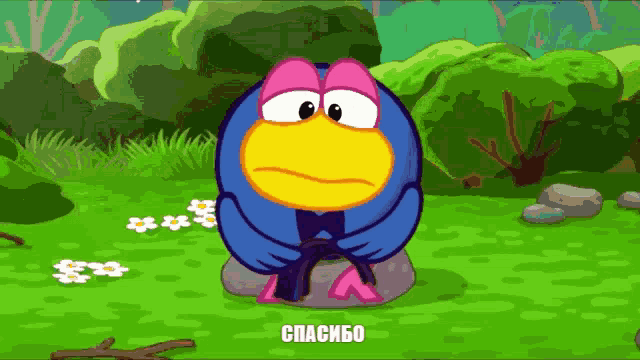

In [217]:
data = pd.concat([data, pd.get_dummies(data.age_restriction).astype(np.int64)], axis=1)
data = pd.concat([data, pd.get_dummies(data["type"]).astype(np.int64)], axis=1)
data = data.drop(columns=["type", "age_restriction"])

- `Date` Поэксперементирую оставлю только год и потом заскалирую его, может и правда раньше кино было лучше?

In [218]:
data.show_start_date = pd.to_datetime(data.show_start_date).dt.year

## Подготовка к обучению

Посмотрим что получилось в итоге

In [219]:
display(data.info())
display(data.head(3))

<class 'pandas.core.frame.DataFrame'>
Index: 6476 entries, 0 to 7483
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   show_start_date                         6476 non-null   int32  
 1   ratings                                 6476 non-null   float64
 2   box_office                              6476 non-null   float64
 3   Is_box_office                           6476 non-null   int64  
 4   multi_producer                          6476 non-null   int64  
 5   multi_dir                               6476 non-null   int64  
 6   multi_studio                            6476 non-null   int64  
 7   is_good_producer                        6476 non-null   int64  
 8   is_good_dir                             6476 non-null   int64  
 9   is_good_studio                          6476 non-null   int64  
 10  is_драма                                6476 non-null   float64
 

None

,show_start_date,ratings,box_office,Is_box_office,multi_producer,multi_dir,multi_studio,is_good_producer,is_good_dir,is_good_studio,...,«12+» - для детей старше 12 лет,«16+» - для детей старше 16 лет,«18+» - запрещено для детей,«6+» - для детей старше 6 лет,Анимационный,Документальный,Музыкально-развлекательный,Научно-популярный,Прочие,Художественный
0,2015,7.2,0.0,0,1,0,1,1,1,1,...,0,0,1,0,0,0,0,0,0,1
1,2016,6.6,0.0,0,0,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,1
2,2016,6.8,0.0,0,1,0,1,1,1,1,...,0,0,1,0,0,0,0,0,0,1


In [220]:
corr = data.drop("ratings", axis=1).corrwith(data.ratings).sort_values(ascending=False)
fig = px.bar(corr, x=corr.index, y=corr.values, color=corr.values, color_continuous_scale='RdYlBu_r')
fig.show()

Всегда замечал, что у ужастиков низкие рейтинги. А год и правда имеет отрицательною корреляцию.

In [221]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [222]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

В box_office нужно закслелить только те записи где есть информация

In [223]:
X, y = data.drop(columns=["ratings"]), data.ratings

In [224]:
scaler = StandardScaler()
_box_mask = (X.Is_box_office == 1)

X.loc[X[_box_mask].index, "box_office"] = scaler.fit_transform(X[_box_mask][["box_office"]])
X["show_start_date"] = scaler.fit_transform(X[["show_start_date"]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = (
    torch.tensor(X_train.values, dtype=torch.float32),
    torch.tensor(X_test.values, dtype=torch.float32),
    torch.tensor(y_train.values, dtype=torch.float32),
    torch.tensor(y_test.values, dtype=torch.float32)
    )

# 2 Построение base-line модели

In [225]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [226]:
class MyRegressor(nn.Module):
    def __init__(
        self,
        n_features,
        f_activation,
        is_drop_out: bool = True,
        p_drop_out: float = 0.1,
        is_batch: bool= True,
        ):

        super(MyRegressor, self).__init__()

        layers = [nn.Linear(n_features, 256, bias=True)]

        if is_batch: layers.append(nn.BatchNorm1d(256))
        layers.append(f_activation())
        if is_drop_out: layers.append(nn.Dropout(p_drop_out))

        layers.append(nn.Linear(256, 64, bias=True))
        if is_batch: layers.append(nn.BatchNorm1d(64))
        layers.append(f_activation())
        if is_drop_out: layers.append(nn.Dropout(p_drop_out))

        layers.append(nn.Linear(64, 1, bias=True))
        layers.append(f_activation())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [227]:
def train(model, train, test, loss_f, optimizer, epochs=1000, logg=True):

    size = len(train.dataset)
    criterion = loss_f
    optimizer = optimizer

    train_loss = 0
    test_loss = 0
    rmse_loss = 0

    train_losses = []
    test_losses = []
    rmse_h = []

    for epoch in range(epochs+1):
        train_loss = 0
        test_loss = 0
        rmse_loss = 0

        model.train()
        for batch, (X, y) in enumerate(train):
          X, y = X.to(device), y.to(device)

          pred = model(X)
          loss = loss_f(pred.squeeze(), y)
          train_loss += loss.item()
          loss.backward()

          optimizer.step()
          optimizer.zero_grad()

        train_losses.append(train_loss / len(train))

        model.eval()
        with torch.no_grad():
          for X, y in test:
              X, y = X.to(device), y.to(device)
              pred = model(X)
              test_loss += loss_f(pred.squeeze(), y).item()

              rmse_loss += np.sqrt(loss_f(pred.squeeze(), y).item())

        test_losses.append(test_loss / len(test))
        rmse_h.append(rmse_loss / len(test))


        if logg and (epoch % 25 == 0):
          print(f"Epoch: {epoch} | TrainLoss: {train_losses[-1]} | TestLoss: {test_losses[-1]} | RMSE: {rmse_h[-1]}")

    print(f"ИТОГО Epoch: {epoch} | TrainLoss: {train_losses[-1]} | TestLoss: {test_losses[-1]} | RMSE: {rmse_h[-1]}")
    return train_losses, test_losses, rmse_h

In [228]:
model = MyRegressor(
        n_features=len(X_train[0]),
        f_activation=nn.LeakyReLU,
        is_drop_out=False,
        is_batch=False,
    )
model.to(device)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=512)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=512)


In [229]:
loss_f = nn.MSELoss()
optimizer = optim.Adam(lr=0.001, params=model.parameters())
epohcs=100
train_l, test_l, rmse = train(model, train_loader, test_loader, loss_f, optimizer, epochs=epohcs)

Epoch: 0 | TrainLoss: 37.69350849498402 | TestLoss: 29.58487065633138 | RMSE: 5.43889947523317
Epoch: 25 | TrainLoss: 0.4801769933917306 | TestLoss: 0.461592694123586 | RMSE: 0.6776161752605464
Epoch: 50 | TrainLoss: 0.4135235168717124 | TestLoss: 0.42674187819163006 | RMSE: 0.6519727492967186
Epoch: 75 | TrainLoss: 0.37768918682228436 | TestLoss: 0.4254274268945058 | RMSE: 0.6510423608473487
Epoch: 100 | TrainLoss: 0.3546042361042716 | TestLoss: 0.43167638778686523 | RMSE: 0.6557129598058294
ИТОГО Epoch: 100 | TrainLoss: 0.3546042361042716 | TestLoss: 0.43167638778686523 | RMSE: 0.6557129598058294


In [230]:
model.eval()
with torch.no_grad():
    pred = model(X_test.to(device))

pred = pred.cpu()
print(mean_absolute_error(y_test, pred))
print(root_mean_squared_error(y_test, pred))
print(r2_score(y_test, pred))

0.520006840519699
0.6671598256346205
0.6309344615610591


In [231]:
def draw_learning(train_l, test_l, rmse, **kawrgs):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=list(range(len(train_l))), y=train_l, mode='lines', name='Train'))
  fig.add_trace(go.Scatter(x=list(range(epohcs)), y=test_l, mode='lines', name='Test'))
  fig.add_trace(go.Scatter(x=list(range(epohcs)), y=rmse, mode='lines', name='RMSE'))
  fig.update_layout(
      height=500,
      width=1200,
      title=f"Модель\n FA:{kawrgs.get("f_activation", "Неизвестно").__name__} | DropOut: {kawrgs.get("is_drop_out", "Неизвестно")} {kawrgs.get("p_drop_out", "Неизвестно")} | BatchSize: {kawrgs.get("batch_size", "Неизвестно")} | BatchNorm: {kawrgs.get("is_batch", "Неизвестно")}")
  fig.show()

In [232]:
draw_learning(train_l, test_l, rmse, f_activation=nn.LeakyReLU)

# 3 Подбор параметров

In [233]:
from sklearn.model_selection import ParameterGrid

In [234]:
params = {
    "f_activation": [nn.ReLU, nn.ELU, nn.LeakyReLU, nn.SiLU],
    "is_drop_out": [True],
    "p_drop_out": [0.0, 0.1, 0.3],
    "is_batch": [True, False],
    "batch_size": [128, 512],
}

table = pd.DataFrame(columns=["ModelNumber", "RMSE", "f_activation", "is_drop_out", "p_drop_out", "is_batch", "batch_size"])
for index, param in enumerate(ParameterGrid(params)):
  model_param = param.copy()
  model_param.pop("batch_size")

  train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=param["batch_size"])
  test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=param["batch_size"])

  model_p = MyRegressor(
        n_features=len(X_train[0]),
        **model_param
        )
  model_p.to(device)

  loss_f = nn.MSELoss()
  optimizer = optim.Adam(lr=0.001, params=model_p.parameters())
  epohcs=50

  print(f"Модель {index}{param}")
  train_l, test_l, rmse = train(model_p, train_loader, test_loader, loss_f, optimizer, epochs=epohcs, logg=False)
  draw_learning(train_l, test_l, rmse, **param)
  print("\n------------------------------------------\n")

  row = pd.DataFrame(
      {
          "ModelNumber": [index],
          "RMSE": [rmse[-1]],
          "f_activation": [param["f_activation"].__name__],
          "is_drop_out": [param["is_drop_out"]],
          "p_drop_out": [param["p_drop_out"]],
          "is_batch": [param["is_batch"]],
          "batch_size": [param["batch_size"]],
      }
  )
  table = pd.concat([table, row], ignore_index=True)

Модель 0{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.ReLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.0}
ИТОГО Epoch: 50 | TrainLoss: 0.1748918850974339 | TestLoss: 0.6232478699900887 | RMSE: 0.7863315633334781



------------------------------------------

Модель 1{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.ReLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.1}


/tmp/ipython-input-737087526.py:43: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



ИТОГО Epoch: 50 | TrainLoss: 0.4690245433551509 | TestLoss: 0.480843568390066 | RMSE: 0.6918783573795727



------------------------------------------

Модель 2{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.ReLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.3}
ИТОГО Epoch: 50 | TrainLoss: 0.9000545144081116 | TestLoss: 0.4986679255962372 | RMSE: 0.7045769621037772



------------------------------------------

Модель 3{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.ReLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.0}
ИТОГО Epoch: 50 | TrainLoss: 0.3242874876028154 | TestLoss: 0.4581285688010129 | RMSE: 0.6744189171889928



------------------------------------------

Модель 4{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.ReLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.1}
ИТОГО Epoch: 50 | TrainLoss: 0.5782782362728585 | TestLoss: 0.43621640313755383 | RMSE: 0.658748854441582



------------------------------------------

Модель 5{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.ReLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.3}
ИТОГО Epoch: 50 | TrainLoss: 0.9819235801696777 | TestLoss: 0.4418142194097692 | RMSE: 0.6630840191779064



------------------------------------------

Модель 6{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.ELU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.0}
ИТОГО Epoch: 50 | TrainLoss: 11.303587238963058 | TestLoss: 9.73949705470692 | RMSE: 3.1076179456042485



------------------------------------------

Модель 7{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.ELU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.1}
ИТОГО Epoch: 50 | TrainLoss: 11.41482504402719 | TestLoss: 9.689377828077836 | RMSE: 3.099672202020943



------------------------------------------

Модель 8{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.ELU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.3}
ИТОГО Epoch: 50 | TrainLoss: 11.595569005826624 | TestLoss: 9.709602616050027 | RMSE: 3.1031600929021694



------------------------------------------

Модель 9{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.ELU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.0}
ИТОГО Epoch: 50 | TrainLoss: 0.4646355858663233 | TestLoss: 0.44105210629376496 | RMSE: 0.6616027935825818



------------------------------------------

Модель 10{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.ELU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.1}
ИТОГО Epoch: 50 | TrainLoss: 0.5477567896610354 | TestLoss: 0.44936306097290735 | RMSE: 0.6672912688077989



------------------------------------------

Модель 11{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.ELU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.3}
ИТОГО Epoch: 50 | TrainLoss: 0.7896371265737022 | TestLoss: 0.44723801992156287 | RMSE: 0.6655947800207925



------------------------------------------

Модель 12{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.0}
ИТОГО Epoch: 50 | TrainLoss: 0.167964142088483 | TestLoss: 0.6534532579508695 | RMSE: 0.806031130336352



------------------------------------------

Модель 13{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.1}
ИТОГО Epoch: 50 | TrainLoss: 0.43971352460907726 | TestLoss: 0.49692612886428833 | RMSE: 0.7036580353395049



------------------------------------------

Модель 14{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.3}
ИТОГО Epoch: 50 | TrainLoss: 0.9098230629432492 | TestLoss: 0.48415759205818176 | RMSE: 0.6940756931023139



------------------------------------------

Модель 15{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.0}
ИТОГО Epoch: 50 | TrainLoss: 0.35531771837211235 | TestLoss: 0.43604191595857794 | RMSE: 0.6585184585870962



------------------------------------------

Модель 16{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.1}
ИТОГО Epoch: 50 | TrainLoss: 0.5500678768972072 | TestLoss: 0.4198089431632649 | RMSE: 0.6459879084875648



------------------------------------------

Модель 17{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.3}
ИТОГО Epoch: 50 | TrainLoss: 0.8094908784075481 | TestLoss: 0.4305995350534266 | RMSE: 0.6540490323075708



------------------------------------------

Модель 18{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.SiLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.0}
ИТОГО Epoch: 50 | TrainLoss: 7.9777935772407345 | TestLoss: 6.993641029704701 | RMSE: 2.6318897051793537



------------------------------------------

Модель 19{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.SiLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.1}
ИТОГО Epoch: 50 | TrainLoss: 8.150698266378264 | TestLoss: 6.9442268068140205 | RMSE: 2.6227016322120473



------------------------------------------

Модель 20{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.SiLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.3}
ИТОГО Epoch: 50 | TrainLoss: 8.352382311006872 | TestLoss: 6.914307507601651 | RMSE: 2.616994714436974



------------------------------------------

Модель 21{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.SiLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.0}
ИТОГО Epoch: 50 | TrainLoss: 0.45245772890928315 | TestLoss: 0.43312887711958453 | RMSE: 0.6553294468184176



------------------------------------------

Модель 22{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.SiLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.1}
ИТОГО Epoch: 50 | TrainLoss: 0.581481924871119 | TestLoss: 0.4387601613998413 | RMSE: 0.6596418811251099



------------------------------------------

Модель 23{'batch_size': 128, 'f_activation': <class 'torch.nn.modules.activation.SiLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.3}
ИТОГО Epoch: 50 | TrainLoss: 0.7806467079534763 | TestLoss: 0.44935139742764557 | RMSE: 0.667413560896271



------------------------------------------

Модель 24{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.ReLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.0}
ИТОГО Epoch: 50 | TrainLoss: 0.24467119591479952 | TestLoss: 0.508208692073822 | RMSE: 0.7122129986692953



------------------------------------------

Модель 25{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.ReLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.1}
ИТОГО Epoch: 50 | TrainLoss: 0.5234899629246105 | TestLoss: 0.46922237674395245 | RMSE: 0.6842797649979486



------------------------------------------

Модель 26{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.ReLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.3}
ИТОГО Epoch: 50 | TrainLoss: 1.0264410755851052 | TestLoss: 0.4909416437149048 | RMSE: 0.7000604580181006



------------------------------------------

Модель 27{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.ReLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.0}
ИТОГО Epoch: 50 | TrainLoss: 0.40982740982012317 | TestLoss: 0.4264160692691803 | RMSE: 0.6518695903355982



------------------------------------------

Модель 28{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.ReLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.1}
ИТОГО Epoch: 50 | TrainLoss: 0.5980835258960724 | TestLoss: 0.42302632331848145 | RMSE: 0.6490280258399564



------------------------------------------

Модель 29{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.ReLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.3}
ИТОГО Epoch: 50 | TrainLoss: 1.0480497154322537 | TestLoss: 0.46090348561604816 | RMSE: 0.6779401577932647



------------------------------------------

Модель 30{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.ELU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.0}
ИТОГО Epoch: 50 | TrainLoss: 11.193964091214267 | TestLoss: 10.260124206542969 | RMSE: 3.200762211523681



------------------------------------------

Модель 31{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.ELU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.1}
ИТОГО Epoch: 50 | TrainLoss: 11.335576577620072 | TestLoss: 10.246508598327637 | RMSE: 3.198629619211506



------------------------------------------

Модель 32{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.ELU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.3}
ИТОГО Epoch: 50 | TrainLoss: 11.582797917452725 | TestLoss: 10.243431409200033 | RMSE: 3.198205844330388



------------------------------------------

Модель 33{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.ELU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.0}
ИТОГО Epoch: 50 | TrainLoss: 0.4992000027136369 | TestLoss: 0.4465196927388509 | RMSE: 0.6661073813131693



------------------------------------------

Модель 34{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.ELU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.1}
ИТОГО Epoch: 50 | TrainLoss: 0.5943779837001454 | TestLoss: 0.44639203945795697 | RMSE: 0.6661220919619651



------------------------------------------

Модель 35{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.ELU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.3}
ИТОГО Epoch: 50 | TrainLoss: 0.8387902866710316 | TestLoss: 0.4486892521381378 | RMSE: 0.6676661494344066



------------------------------------------

Модель 36{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.0}
ИТОГО Epoch: 50 | TrainLoss: 0.3055163858966394 | TestLoss: 0.5205026070276896 | RMSE: 0.7214115028035707



------------------------------------------

Модель 37{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.1}
ИТОГО Epoch: 50 | TrainLoss: 0.535730551589619 | TestLoss: 0.46238671739896137 | RMSE: 0.6790912377419637



------------------------------------------

Модель 38{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.3}
ИТОГО Epoch: 50 | TrainLoss: 1.077427620237524 | TestLoss: 0.4675849378108978 | RMSE: 0.682336223927425



------------------------------------------

Модель 39{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.0}
ИТОГО Epoch: 50 | TrainLoss: 0.42962054772810504 | TestLoss: 0.43758343656857807 | RMSE: 0.6606600499710037



------------------------------------------

Модель 40{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.1}
ИТОГО Epoch: 50 | TrainLoss: 0.5939696024764668 | TestLoss: 0.4346088469028473 | RMSE: 0.6578623607315106



------------------------------------------

Модель 41{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.3}
ИТОГО Epoch: 50 | TrainLoss: 1.2229866222901777 | TestLoss: 0.44819725553194684 | RMSE: 0.6684621466986344



------------------------------------------

Модель 42{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.SiLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.0}
ИТОГО Epoch: 50 | TrainLoss: 5.846043890172785 | TestLoss: 5.6455403963724775 | RMSE: 2.3708632759257093



------------------------------------------

Модель 43{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.SiLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.1}
ИТОГО Epoch: 50 | TrainLoss: 5.991027441891757 | TestLoss: 5.631822903951009 | RMSE: 2.3678626048927396



------------------------------------------

Модель 44{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.SiLU'>, 'is_batch': True, 'is_drop_out': True, 'p_drop_out': 0.3}
ИТОГО Epoch: 50 | TrainLoss: 8.379042928869074 | TestLoss: 7.344130198160808 | RMSE: 2.707856131250199



------------------------------------------

Модель 45{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.SiLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.0}
ИТОГО Epoch: 50 | TrainLoss: 0.494764119386673 | TestLoss: 0.45069217681884766 | RMSE: 0.6693236814761812



------------------------------------------

Модель 46{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.SiLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.1}
ИТОГО Epoch: 50 | TrainLoss: 0.6290878220037981 | TestLoss: 0.45094285408655804 | RMSE: 0.6697325465698493



------------------------------------------

Модель 47{'batch_size': 512, 'f_activation': <class 'torch.nn.modules.activation.SiLU'>, 'is_batch': False, 'is_drop_out': True, 'p_drop_out': 0.3}
ИТОГО Epoch: 50 | TrainLoss: 0.9976715770634738 | TestLoss: 0.4548775951067607 | RMSE: 0.6725525591838464



------------------------------------------



In [235]:
table.sort_values("RMSE")

,ModelNumber,RMSE,f_activation,is_drop_out,p_drop_out,is_batch,batch_size
16,16,0.645988,LeakyReLU,True,0.1,False,128
28,28,0.649028,ReLU,True,0.1,False,512
27,27,0.651870,ReLU,True,0.0,False,512
17,17,0.654049,LeakyReLU,True,0.3,False,128
21,21,0.655329,SiLU,True,0.0,False,128
40,40,0.657862,LeakyReLU,True,0.1,False,512
15,15,0.658518,LeakyReLU,True,0.0,False,128
4,4,0.658749,ReLU,True,0.1,False,128
22,22,0.659642,SiLU,True,0.1,False,128
39,39,0.660660,LeakyReLU,True,0.0,False,512


# Итоги

В ходе лабораторной работы был проведен EDA, построена построена основная архитектура модели полносвязной НС. На основе этой архитектуры проведен подбор параметров на 48 моделей.

Лучший показатель `RMSE` дала модель 16 с ошибкой 0.65, ее параметры можно наблюдать в таблице выше.

Хорошим решением оказалось, подсказать модели хороших режиссеров, студии и продюссеров. Это позволило снизить абсолютную ошибку с 1 до 0.5 в определении рейтинга. Правда в будущем потребует дообучать модель под новые данные.

В данном случае задачи регрессии лучше всего применять relu-like функции активации, пробовал использовать нелинейные `tanh` и `sigmoid` в первом скрытом слое, но к хорошему результату это не привело. Включение drop out и увелечение вероятности неизбежно ведек к росту ошибки, что и логично, и даже в случае переобучения мне показалось что лучше снизить количество эпох, чем включать дроп аут для данной задачи.